# Lab 2: Supervised Learning

In this lab, we prepare our Kiva data for a linear regression, and run linear regressions that attempt to answer our research questions: 

1. What are the determining factors of how much borrowers request? 
2. How much of a loan gets funded? 
3. How long does it take for a loan to get funded?

These three questions are in fact subquestions that we want to investigate given our interest in who Kiva's borrowers are. In the language of Module 1, our outcome features are: 

1. loan_amount
2. funded_amount 
3. days_to_fund (we will make this variable in this notebook!) 

We will try using and evaluating different explanatory features in this notebook. 

But first, we will load the packages we need for this section, and our data. As a reminder, we had 3 raw data files (loans_full, loans_detail, and loans_partner_details). In Notebook 1, we merged these data files to form the data frame "df", which we will  use now.  

In [12]:
## Import packages

import pandas as pd
import numpy as np
import re
from datetime import datetime
from ggplot import *
%matplotlib inline

In [18]:
## Read in data

##data_path = '~/intro_to_machine_learning/data'
data_path = '~/Desktop'
df = pd.read_csv(data_path+'/df.csv', low_memory=False)

## Creating Explanatory Features of Interest

   ### Demographics

Since we are interested in using the demographics of the Kiva borrowers as potential explanatory features, we will create these based on existing data. See how below: 

#### Age

As it appears Kiva does not collect the age of their borrowers, we do not have a ready-made age feature. However, we do have descriptions that borrowers submit, and sometimes, borrowers mention their age. We can extract this age feature using regular expressions. In the snippet below, we search for any instance of "# yrs" or "# years", where # can be between 1 and 100. 

In [ ]:
# Here we define a function "age_search" that searches for an indication of someone's age.
# The function returns the age if found, and 0 if not found. 

#### DEVELOPMENT NOTES ###### 
## Probably a faster way to do this using apply .. a good intro to loops but the time it takes is restrictive
# Yields 15,343 instances in which age>0
# **to update: spot check for inaccurate matches - some fields list ages of children of borrower 
#    if younger than 18, flag? 
 

def age_search(x): 
    if re.search("([0-9]|[1-9][0-9]) (yrs|years)", x) is not None:
        return re.search("([0-9]|[1-9][0-9]) (yrs|years)", x).group(1)
    else:
        return 0

print(age_search(df['description.texts.en'][1]))

df['age'] = 0

for i in range(1, len(df)):
    if re.search("([0-9]|[1-9][0-9]) (yrs|years)", df['description.texts.en'][i]) is not None:
        df['age'][i] = re.search("([0-9]|[1-9][0-9]) (yrs|years)", df['description.texts.en'][i]).group(1)
    else:
        df['age'][i] = 0

In [22]:
## Male/Female 
#  Note the apply function
df['male'] = df['borrowers'].apply(lambda x: x.split("gender': '")[1][0]=='M')

## Whether or not the borrower is widowed
#  Note the str.contains function
df['widowed'] = np.where(df['description.texts.en'].str.contains("widowed|widow", na=False) ==True, True, False)

## Whether or not the borrower has children 
df['kids'] = np.where(df['description.texts.en'].str.contains("kids|child|children|kid|son|daughter", na=False) ==True,True,False)

Here we see two new methods: apply and string searches. 

In creating the "male" feature, we are using apply

In creating the "widowed" and "kids" feature, we are using Numpy's "where" function and "str.contains" to filter the data such that we are only creating a Boolean variable for those observations in which we find the strings of interest. 

Read more here

### Loan features

Next we create features that tell us the specific conditions surrounding each loan posting, including: 
1. Whether or not a borrower has included a video or a picture

    Here, our intuition tells us that if a borrower includes more personal details and imagery, lenders are more likely to lend to them. We create this variable so we can differentiate between loans that have these personal details and loans that do not.

    
2. When loans are funded
3. When loans are disbursed
4. When loans expire

In [23]:
## Features of the loan posting

## Does the borrower include a video? 
df['video'] = np.where(pd.isnull(df['video.id']) ==False, True, False)

## Does the borrower include a picture? 
df['pictured'] = df['borrowers'].apply(lambda x: x.split("gender': '")[1][0]==True)

In order to get information on how much time it took for a loan to be funded or be disbursed or expire, we first need to make sure that the data is in Python's datetime format. Once all relevant features are converted to this format, we can perform operations on them. In this case, we want to find out how many days elapsed between two dates, so we subtract the earlier date from the later date. 

In [24]:
df = df.rename(columns={'terms.disbursal_date': 'disbursal_date'})

## convert columns to datetime format
df['funded_date_cln'] = pd.to_datetime(df.funded_date.str[:10], infer_datetime_format=True)
df['post_date_cln'] = pd.to_datetime(df.posted_date.str[:10], infer_datetime_format=True)
df['disb_date_cln'] = pd.to_datetime(df.disbursal_date.str[:10], infer_datetime_format=True)
df['exp_date_cln'] = pd.to_datetime(df.planned_expiration_date.str[:10], infer_datetime_format=True)

## Time to fund is the funded date minus the posted date
df['time_to_fund'] =df['funded_date_cln'] - df['post_date_cln']
df['days_to_fund'] = df.time_to_fund.dt.days

## Time to dispursement is the Disbursed date minus the Posted Date
df['time_to_disb'] =df['disb_date_cln'] - df['post_date_cln']
df['days_to_disb'] = df.time_to_disb.dt.days

## Time to expiration is the expiration date minus the Posted Date
df['time_to_exp'] =df['exp_date_cln'] - df['post_date_cln']
df['days_to_exp'] = df.time_to_exp.dt.days

## Exploring Potential Relationships

There are a number of relationships we could explore in this data, and just as many ways to slice, dice and visualize the data. Here, we offer some examples of exploratory directions. 

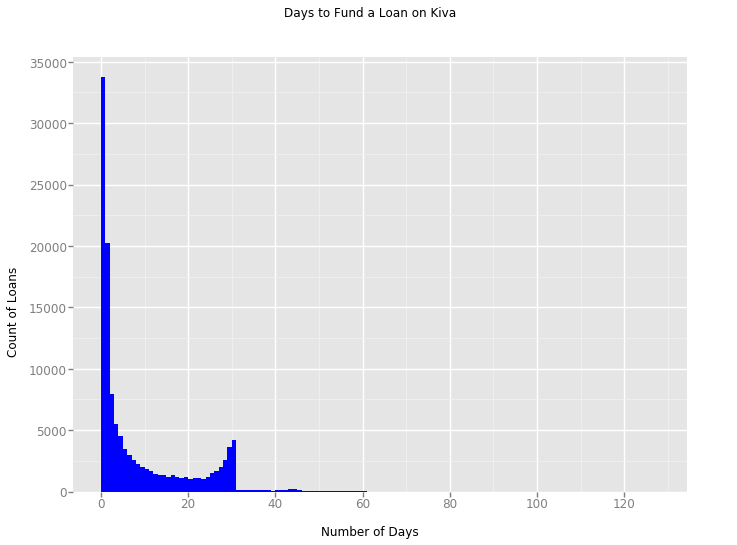

<ggplot: (146309195461)>

In [25]:
ggplot(df.query('days_to_fund >= 0'), aes(x='days_to_fund')) + geom_histogram(binwidth=1, fill="blue") + \
ggtitle("Days to Fund a Loan on Kiva") + xlab("Number of Days") + ylab("Count of Loans")

Interestingly, most loans are funded astoundingly quickly! The majority of loans are funded 0 days after being posted. There is also a spike that occurs around the 30 day mark, suggesting that there is a cluster of loans that are funded before the expiration date of 30 days.

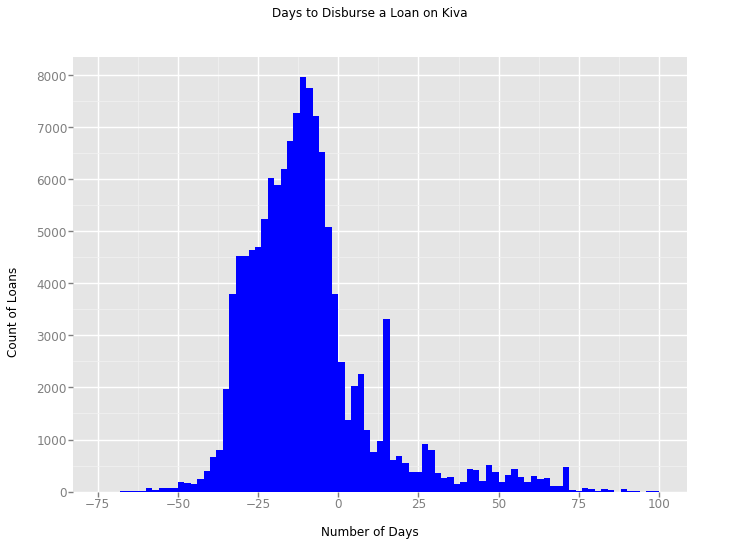

<ggplot: (-9223371958060794396)>

In [81]:
ggplot(df.query('days_to_disb < 100 & days_to_disb > -100'), aes(x='days_to_disb')) + geom_histogram(binwidth=2, fill="blue") + \
ggtitle("Days to Disburse a Loan on Kiva") + xlab("Number of Days") + ylab("Count of Loans")

Note that this histogram exhibits a normal distribution. Interestingly, it is centered around -10. This implies that the average loan gets disbursed to the borrower <b>prior</b> to getting posted. 

At this point, we would consult with Kiva to make sure that our understanding of the data is correct. Based on our conversations with Kiva representatives, we found out that Kiva encourages partners to disburse loans to borrowers in case there are time-sensitive loans. In the area of agriculture, for example, it is understandable that a borrower might need capital right away in order to plant crops while the season is right. 

Now let's look to the demographic features we created.

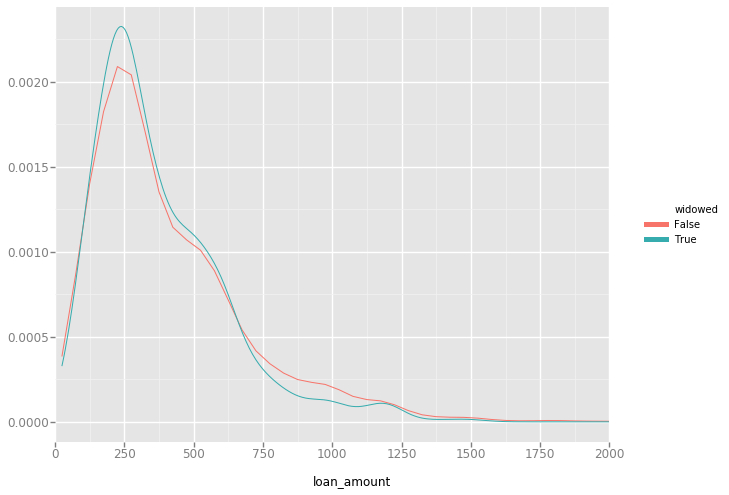

<ggplot: (-9223371958048018088)>

In [84]:
ggplot(df.query('male == False'), aes(x='loan_amount',colour=str('widowed'))) + geom_density() + xlim(0,2000)

In this graph, we create a density graph for two populations in the data: female borrowers who are widowed, and female borrowers who are not widowed. Note that we subset the data for females only using "query" on our data frame. A density graph is conceptually very similar to a histogram. We see that female borrowers who are widowed tend to receive slightly smaller loans. This is interesting - to dig into this more, let's look at female borrowers who are widowed and the time it takes them to fund their loans. 

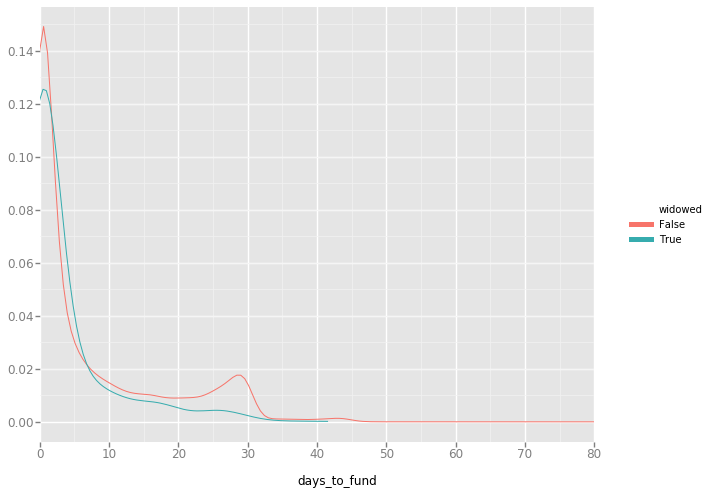

<ggplot: (-9223371958047097277)>

In [85]:
ggplot(df.query("male == False"), aes(x='days_to_fund',colour=str('widowed'))) + geom_density() + xlim(0,80)

This density graph shows that female borrowers who are NOT widowed tend to take a longer time to fund. They appear to benefit from the 30-day expiration date spike in activity, whereas there is no such spike in activity for female borrowers who are widowed. 

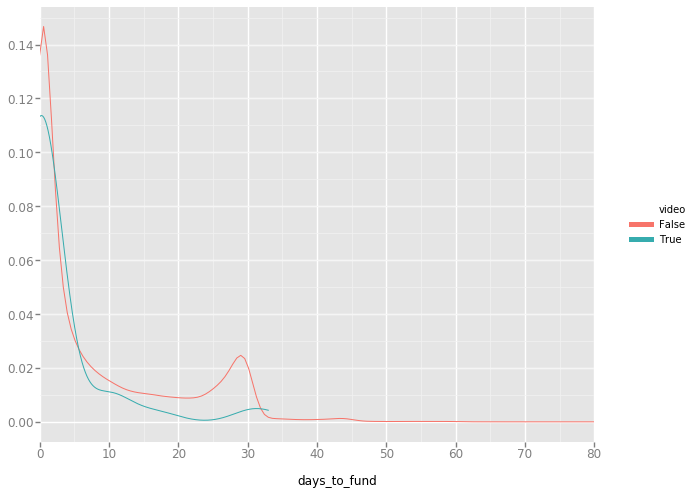

<ggplot: (146313902891)>

In [81]:
ggplot(df, aes(x='days_to_fund',colour=str('video'))) + geom_density() + xlim(0,80)

## Checking Assumptions

Now that we have an idea of what some relationships in the data look like, let's start preparing for linear regression by turning to assumptions. 

### Check for Normality 

We have already generated some histograms that tell us that a few of our outcome features are not normally distributed. We focus in on the loan_amount variable here and suggest one possible solution. 

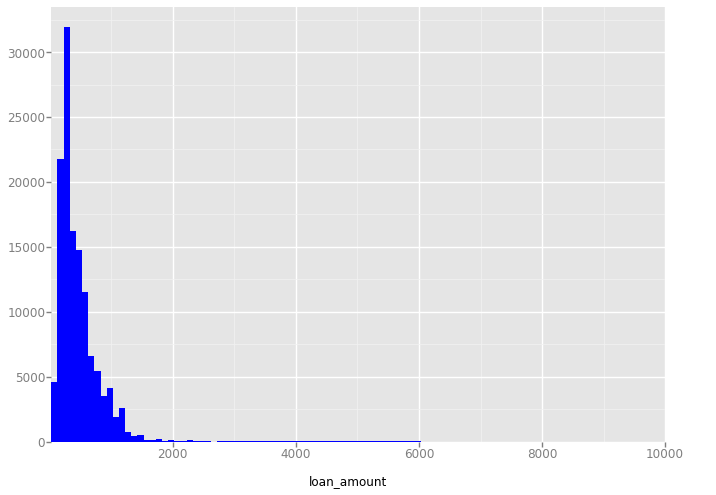

<ggplot: (-9223371890542156144)>

In [91]:
ggplot(df, aes(x='loan_amount')) + geom_histogram(binwidth=100, fill = "blue") + xlim(25,10000)

This graph demonstrates that loan amounts requested are skewed very heavily towards 25, which we know to be the lowest possible amount you can request on Kiva. This conflicts with the assumptions underlying linear regression, and makes our model more representative of these low-value loans, which makes the predictive value of any consequent linear regression model lower for loans that may not be low-value. One possible solution is to log transform this variable. **Read more about log exponentiation here**  We demonstrate below. 

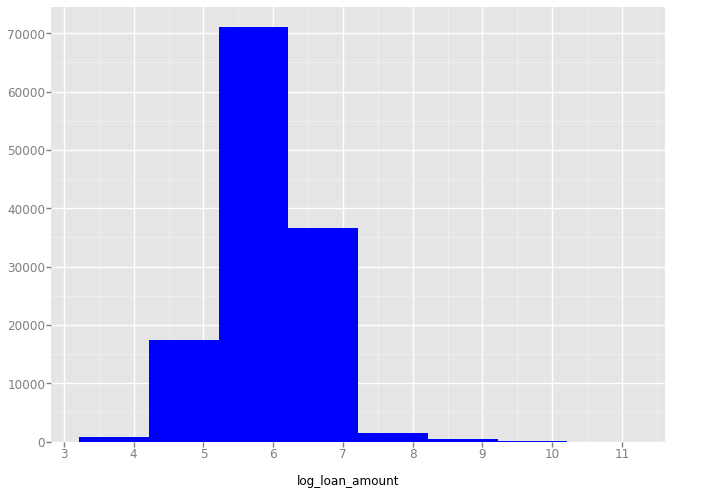

<ggplot: (-9223371890541358318)>

In [92]:
df['log_loan_amount'] = np.log(df['loan_amount'])

ggplot(df, aes(x='log_loan_amount')) + geom_histogram(binwidth=1, fill = "blue")

This new graph is much closer to normally distributed than our skewed first graph. 

Note, however, that if you log transform variables, it is necessary to take care in interpreting your output. 

Read more about log-log and log-linear regression models. http://home.wlu.edu/~gusej/econ398/notes/logRegressions.pdf 

### Check for multicollinearity

Numpy's Corrcoef function returns a matrix of Pearson correlation coefficients. To recap Module 2's lesson, multicollinearity is a problem when we have highly correlated explanatory features, as this makes it difficult for the model to try to differentitae between each feature's influence on the explanatory feature. Read more about multicollinearity here: XXXXXX

Try running different features!

In [101]:
np.corrcoef(df.borrower_count, df.funded_amount)

array([[ 1.        ,  0.20718916],
       [ 0.20718916,  1.        ]])

In [96]:
np.corrcoef(df.lender_count, df.funded_amount)

array([[ 1.        ,  0.95874758],
       [ 0.95874758,  1.        ]])

## Linear Regression

Now we're relatively confident about what our data looks like, let's try some regressions. We will focus in on one outcome feature, time_to_fund. We encourage you to explore the other two outcome features we identified earlier in this class!  

As discussed in Module 2, we will divide the data into training and test sets so we can validate our regression results.

Note that training set should be larger than the test set, as we should train our model on as much data as possible. For this example, we divide the data 80% training / 20% test.

In [26]:
import statsmodels.formula.api as sm

# Set training-test split %
split_pct = 0.80

# the pandas command "sample" already randomizes its selection. 
loans_full_shuffled = df.sample(frac=1)

train_set = loans_full_shuffled[:int((len(loans_full_shuffled)+1*split_pct))] 
test_set = loans_full_shuffled[int(len(loans_full_shuffled)*split_pct+1):]  

# Now we have two separate datasets: train_set and test_set. We will run the regression on train_set
# using statsmodel's "ols" function. Let's try a simple example to start:

model1 = sm.ols(formula="days_to_fund ~ loan_amount", data=train_set).fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:           days_to_fund   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     2448.
Date:                Thu, 25 May 2017   Prob (F-statistic):               0.00
Time:                        08:59:55   Log-Likelihood:            -4.8066e+05
No. Observations:              122331   AIC:                         9.613e+05
Df Residuals:                  122329   BIC:                         9.613e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept       6.9034      0.043    161.535      

This is a lot to digest! Remember that our simple model can be represented as a linear equation, like this: 

    days_to_fund = intercept + coef*loan_amount

Therefore, these results can be translated as follows: 

    days_to_fund = 6.9017 + 0.0026*loan_amount

Noticeably, the coefficient for loan_amount is very small, suggesting that loan_amount does not actually influence days_to_fund all that much. Additionally, the Adjusted R Squared is 0.02 - extremely low. Both of these things suggest that the predictive value of loan_amount is pretty low - it cannot be used as the single feature to predict days_to_fund. 

This result is in line with our understanding of the world - there must be other factors influencing days_to_fund. Let's try complicating the model by adding more explanatory features. 

In [27]:
model2 = sm.ols(formula="days_to_fund ~ days_to_exp + borrower_count + loan_amount + sector + kids + male+ widowed + pictured + video", data=train_set).fit()
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:           days_to_fund   R-squared:                       0.124
Model:                            OLS   Adj. R-squared:                  0.124
Method:                 Least Squares   F-statistic:                     657.7
Date:                Thu, 25 May 2017   Prob (F-statistic):               0.00
Time:                        08:59:58   Log-Likelihood:            -3.6718e+05
No. Observations:               97418   AIC:                         7.344e+05
Df Residuals:                   97396   BIC:                         7.346e+05
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------
Intercept               

** commentary about results -- highest negative coef is whether or not borrower includes video

In [79]:
model3 = sm.ols(formula="loan_amount ~ days_to_exp + borrower_count + loan_amount + sector + kids + male+ widowed + pictured + video", data=train_set).fit()
print(model3.summary())

                            OLS Regression Results                            
Dep. Variable:            loan_amount   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.113e+33
Date:                Thu, 25 May 2017   Prob (F-statistic):               0.00
Time:                        11:53:51   Log-Likelihood:             2.6548e+06
No. Observations:              103045   AIC:                        -5.309e+06
Df Residuals:                  103023   BIC:                        -5.309e+06
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------
Intercept               

In [80]:
model4 = sm.ols(formula="funded_amount ~ days_to_exp + borrower_count + loan_amount + sector + kids + male+ widowed + pictured + video", data=train_set).fit()
print(model4.summary())

                            OLS Regression Results                            
Dep. Variable:          funded_amount   R-squared:                       0.948
Model:                            OLS   Adj. R-squared:                  0.948
Method:                 Least Squares   F-statistic:                 8.882e+04
Date:                Thu, 25 May 2017   Prob (F-statistic):               0.00
Time:                        11:54:33   Log-Likelihood:            -6.7155e+05
No. Observations:              103045   AIC:                         1.343e+06
Df Residuals:                  103023   BIC:                         1.343e+06
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------
Intercept               

A note regarding different models: We saw earlier that most loans get fully funded. This would mean that we would expect the model with loan_amount as the explanatory variable to yield results that are similar to the model with funded_amount as the explanatory variable. We run both models to check this understanding. 

## Model Validation

<i>How can we evaluate how our model is doing? </i>

In the previous section, we were able to get general ideas of how well our model was doing by using metrics like Adjusted R Squared, coefficients, and p-value. However, the goal of most machine learning is a model that is <b>predictive</b>. Recall that we randomly split our dataset into a training set (80%) and a test set (20%). Now we will use the results from the regression conducted on our training set to predict the outcome features for each observation in our test set. The difference between the predicted outcome feature and the actual outcome feature for each observation gives us an idea of how close we are to the mark.  

In [99]:
#### DEVELOPMENT NOTES ####
#Sci-kit learn has a way to do this, but statsmodels lets you deal with variables in a more intuitive way 
#There may be a way to combine statsmodel outputs with sci-kit learn test-train prediction ability
# To be updated 

model2_params = model2.params
print(model2_params)

#test_set['intercept'] = params[0]
#test_set['beta1'] = params[1]

Intercept                   6.181722e-13
sector[T.Arts]              2.646772e-13
sector[T.Clothing]         -2.433609e-13
sector[T.Construction]      4.509171e-12
sector[T.Education]         5.364598e-12
sector[T.Entertainment]    -8.704149e-12
sector[T.Food]              3.321787e-13
sector[T.Health]            3.339551e-12
sector[T.Housing]           3.701928e-12
sector[T.Manufacturing]    -9.057644e-12
sector[T.Personal Use]      1.319833e-12
sector[T.Retail]            8.686385e-13
sector[T.Services]          5.231371e-13
sector[T.Transportation]    1.658673e-13
sector[T.Wholesale]         9.080736e-12
kids[T.True]               -1.900702e-13
male[T.True]               -4.369838e-13
widowed[T.True]            -1.234568e-13
pictured[T.True]           -1.079789e-21
video[T.True]               2.273737e-11
days_to_exp                 9.072604e-16
borrower_count             -1.776357e-15
loan_amount                 1.000000e+00
dtype: float64
